In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [155]:
# Load the dataset, drop some unneccessary column to resize
data = pd.read_csv("final_merged_data.csv")
data = data.loc[:, ~data.columns.str.contains("quality_indicator")]

In [156]:
pd.set_option('display.max_columns', None)
data.describe()



,station_id,num_bikes_available,num_docks_available,lat,lon,capacity,stno,year,month,day,hour,minute,max_air_temperature_celsius,min_air_temperature_celsius,air_temperature_std_deviation,max_grass_temperature_celsius,min_grass_temperature_celsius,grass_temperature_std_deviation,max_soil_temperature_5cm_celsius,min_soil_temperature_5cm_celsius,soil_temperature_std_deviation_5cm,max_soil_temperature_10cm_celsius,min_soil_temperature_10cm_celsius,soil_temperature_std_deviation_10cm,max_soil_temperature_20cm_celsius,min_soil_temperature_20cm_celsius,soil_temperature_std_deviation_20cm,max_earth_temperature_30cm_celsius,min_earth_temperature_30cm_celsius,earth_temperature_std_deviation_30cm,max_earth_temperature_50cm_celsius,min_earth_temperature_50cm_celsius,earth_temperature_std_deviation_50cm,max_earth_temperature_100cm_celsius,min_earth_temperature_100cm_celsius,earth_temperature_std_deviation_100cm,max_relative_humidity_percent,min_relative_humidity_percent,relative_humidity_std_deviation,max_barometric_pressure_hpa,min_barometric_pressure_hpa,barometric_pressure_std_deviation
count,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.0,298946.0,298946.0,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000
mean,57.967138,12.204733,19.335198,53.345521,-6.263842,31.979003,175.0,2024.0,12.0,15.717484,11.522128,24.878941,7.855169,7.716685,0.040432,6.564362,6.229473,0.100257,7.047128,7.007714,0.009456,7.159650,7.125825,0.007945,7.258614,7.225430,0.007645,7.390959,7.358199,0.007551,7.995048,7.964415,0.007055,9.437616,9.406651,0.007106,85.021124,83.548719,0.377589,1014.855870,1014.689671,0.045488
std,33.958176,9.761814,11.001506,0.007538,0.017855,7.459101,0.0,0.0,0.0,8.896832,6.280459,17.112726,3.123094,3.136997,0.038731,3.901582,3.946463,0.105303,1.508867,1.509558,0.003023,1.232544,1.233239,0.001651,0.975946,0.976103,0.001110,0.876321,0.876168,0.001084,0.537950,0.537683,0.000938,0.280474,0.280232,0.000920,7.867297,8.160979,0.232676,11.823993,11.894264,0.038661
min,1.000000,0.000000,0.000000,53.330090,-6.310015,16.000000,175.0,2024.0,12.0,1.000000,0.000000,0.000000,-3.448000,-3.521000,0.003000,-8.950000,-9.050000,0.006000,3.231000,3.195000,0.004000,4.578000,4.545000,0.004000,5.285000,5.251000,0.005000,5.624000,5.593000,0.004000,6.903000,6.875000,0.004000,9.030000,9.000000,0.004000,56.700000,52.970000,0.072000,975.060000,975.010000,0.004000
25%,28.000000,4.000000,11.000000,53.339764,-6.275071,29.000000,175.0,2024.0,12.0,8.000000,7.000000,10.000000,5.736000,5.615000,0.017000,4.282000,4.014000,0.032000,5.899000,5.849000,0.007000,6.196000,6.166000,0.007000,6.422000,6.390000,0.007000,6.655000,6.622000,0.007000,7.533000,7.503000,0.006000,9.250000,9.220000,0.006000,80.600000,78.910000,0.230000,1006.010000,1005.770000,0.022000
50%,57.000000,11.000000,19.000000,53.345203,-6.262501,30.000000,175.0,2024.0,12.0,16.000000,12.000000,20.000000,7.955000,7.790000,0.030000,7.140000,6.773000,0.066000,7.108000,7.069000,0.009000,7.140000,7.108000,0.008000,7.200000,7.166000,0.008000,7.344000,7.315000,0.008000,7.969000,7.939000,0.007000,9.340000,9.310000,0.007000,86.000000,84.700000,0.314000,1017.210000,1017.060000,0.034000
75%,88.000000,19.000000,28.000000,53.350292,-6.250900,40.000000,175.0,2024.0,12.0,23.000000,16.000000,40.000000,10.190000,10.070000,0.052000,9.460000,9.150000,0.130000,8.350000,8.320000,0.011000,8.260000,8.230000,0.009000,8.140000,8.110000,0.008000,8.180000,8.150000,0.008000,8.490000,8.460000,0.008000,9.650000,9.620000,0.008000,90.300000,89.000000,0.450000,1022.660000,1022.570000,0.057000
max,117.0

In [157]:
#PREPARE DATA

# Handle missing values (drop rows with NaN in lagged features)
data.dropna(inplace=True)
# Calculate avg for weather:
data['temperature'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2
data['humidity'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2
data['pressure'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2
#Calculate day of week:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_week'] = data['date'].dt.weekday
data = data[['station_id','temperature', 'humidity', 'pressure', 'hour', 'day_of_week', 'num_bikes_available']]
# Save the cleaned version
data.to_csv("final_data_for_ml.csv", index=False)


In [154]:
data = pd.read_csv("final_data_for_ml.csv.csv")
data['station_id'] = data['station_id'].astype('category')
data.head()
data.describe()

,temperature,humidity,pressure,hour,day_of_week,num_bikes_available
count,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000,298946.000000
mean,7.785927,84.284922,1014.772770,11.522128,2.923478,12.204733
std,3.129450,8.004812,11.859002,6.280459,2.060851,9.761814
min,-3.484500,55.070000,975.035000,0.000000,0.000000,0.000000
25%,5.676500,79.770000,1005.915000,7.000000,1.000000,4.000000
50%,7.872000,85.350000,1017.125000,12.000000,3.000000,11.000000
75%,10.125000,89.600000,1022.615000,16.000000,5.000000,19.000000
max,14.630000,98.850000,1035.775000,23.000000,6.000000,40.000000


In [198]:
#Handle hour using cyclinal encoding

# Define features and target
features = ['station_id','temperature', 'humidity', 'pressure', 'hour', 'day_of_week']
target = 'num_bikes_available'

X = data[features]
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [199]:
#TRAINING 

# --- Define preprocessing for categorical column ---
categorical_features = ['station_id']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # Using one-hot encoder to create dummy variable for categorical
    ],
    remainder='passthrough' 
)

# --- Create pipeline with preprocessing and model ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Train a linear regression model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Access the trained model from inside the pipeline
regressor = pipeline.named_steps['regressor']

# Get the one-hot encoder from the pipeline
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Generate the names of the one-hot encoded features
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Define numerical features manually (not encoded)
numeric_features = ['temperature', 'humidity', 'pressure', 'hour', 'day_of_week']

# Combine all feature names
all_feature_names = list(ohe_feature_names) + numeric_features
print("\nModel Coefficients:")
for feature, coef in zip(all_feature_names, regressor.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {regressor.intercept_}")


# Save the model to a .pkl file
model_filename = "project/data/bike_availability_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(pipeline, file)

print(f"Model saved to {model_filename}")

Mean Absolute Error: 6.258301099560472
R² Score: 0.3472839776407466

Model Coefficients:
station_id_2: -17.621752590704922
station_id_3: -13.48799503775612
station_id_4: -10.016526207775788
station_id_5: -2.1084700574417026
station_id_6: -12.755850307805728
station_id_7: -14.532935811428084
station_id_8: -5.5886363277608
station_id_9: -7.1139319836813995
station_id_10: -7.972984601995736
station_id_11: -5.1649378736287055
station_id_12: -17.843757692623345
station_id_13: -7.678664351562818
station_id_14: -1.286974556862732
station_id_15: -18.311206275244512
station_id_16: -9.33479184427735
station_id_17: -11.977376619872707
station_id_18: -9.961713744926866
station_id_19: -10.358874322115778
station_id_20: -13.803925871367968
station_id_21: -3.7330958966793313
station_id_22: -8.699587030125777
station_id_23: -1.5253070235127955
station_id_24: -10.118769672065172
station_id_25: -9.11025179967136
station_id_26: -7.904272909892767
station_id_27: -8.106573356790005
station_id_28: -10.21016

FileNotFoundError: [Errno 2] No such file or directory: 'project/data/bike_availability_model.pkl'

In [197]:

# Load the saved model
with open("bike_availability_model.pkl", "rb") as file:
    model = pickle.load(file)

# Define new input data for prediction
new_data = pd.DataFrame({
    'station_id': [5],
    'temperature': [9.55],
    'humidity': [88],
    'pressure': [1022],
    'hour': [16],
    'day_of_week': [1]  
})

# Make prediction
prediction = model.predict(new_data)
# Output prediction
print(f"Predicted number of available bikes: {round(prediction[0])}")



Predicted number of available bikes: 18


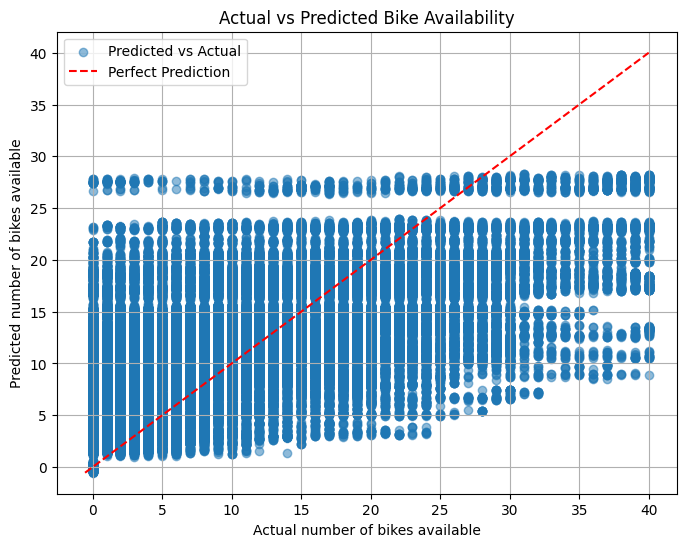

In [158]:
#TESTING
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot perfect prediction line (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual number of bikes available")
plt.ylabel("Predicted number of bikes available")
plt.title("Actual vs Predicted Bike Availability")
plt.legend()
plt.grid(True)
plt.show()


In [162]:
print(y_train.mean()) 
frequency_table = data['num_bikes_available'].value_counts(normalize=True).sort_index() * 100

print(frequency_table)


12.232555361221818
num_bikes_available
0     9.576646
1     6.116155
2     5.001907
3     4.201093
4     3.800686
5     3.599981
6     3.495615
7     3.400280
8     3.416671
9     3.202920
10    3.254434
11    3.086845
12    3.025965
13    3.453801
14    3.163113
15    3.174152
16    3.117620
17    2.875101
18    3.068447
19    2.707178
20    2.820576
21    2.038161
22    1.928107
23    1.839128
24    1.769550
25    1.743459
26    1.340041
27    1.240023
28    1.414302
29    1.395570
30    1.593264
31    0.579369
32    0.499087
33    0.384685
34    0.355248
35    0.327484
36    0.329491
37    0.343875
38    0.330494
39    0.489052
40    0.500425
Name: proportion, dtype: float64
